# Simulation of N-body system
By: Magnus Kvåle Helliesen

We (or at least I) want to simulate the dynamics of an $N$-body system of (celestial) bodies. In order to do this, we make two classes, a **Body** and a **System** of bodies, that contain the neccesary information and methods to carry out such a simulation.

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

## Body class
We start by making a class containing all relevant information for any given body. That is, initial position, velocity and mass. In addition, we allow for updating of position and velocity for any given time.

In [2]:
# Let's make a class holding properties of a celestial body
class Body():
    def __init__(self,
                 position_0: tuple,
                 velocity_0: tuple,
                 mass: float):
        # Cheking for type errors
        if isinstance(position_0, tuple) is False:
            raise TypeError('position_0 must be tuple')
        if all(isinstance(x, float) or isinstance(x, int) for x in position_0) is False:
            raise TypeError('all values of position_0 must be float or int')

        if isinstance(velocity_0, tuple) is False:
            raise TypeError('velocity_0 must be tuple')
        if all(isinstance(x, float) or isinstance(x, int) for x in velocity_0) is False:
            raise TypeError('all values of velocity_0 must be int')

        if (isinstance(mass, float) or isinstance(mass, int)) is False:
            raise TypeError('mass must be float or int')

        # Setting attributes that cannot be changed
        self._position_0 = position_0
        self._velocity_0 = velocity_0
        self._mass = mass

        # Setting attributes that can be changed
        self._position_t = position_0
        self._velocity_t = velocity_0

    @property
    def position_0(self):
        return self._position_0

    @property
    def velocity_0(self):
        return self._velocity_0

    @property
    def mass(self):
        return self._mass

    @property
    def position_t(self):
        return self._position_t

    @property
    def velocity_t(self):
        return self._velocity_t

    @position_t.setter
    def position_t(self, value):
        if isinstance(value, tuple) is False:
            raise TypeError('position must be tuple')
        if all(isinstance(x, float) or isinstance(x, int) for x in value) is False:
            raise ValueError('all values of position must be float or int')
        self._position_t = value

    @velocity_t.setter
    def velocity_t(self, value):
        if isinstance(value, tuple) is False:
            raise TypeError('velocity must be tuple')
        if all(isinstance(x, float) or isinstance(x, int) for x in value) is False:
            raise ValueError('all values of velocity must be float or int')
        self._velocity_t = value

    def __str__(self):
        return f'Body with mass {self.mass} and initial position {self.position_0} and velocity {self.velocity_0}'

    def __repr__(self):
        return self.__str__()

## System class
We then make a class that holds instances of body classes. The system class has a method to simulate how the bodies move over time according to
$\vec{F}_i = m_i\vec{a}_i \iff \vec{a}_i = \vec{F}_i/m_i$ for each body $i$. The (net) force acting on body $i$ is
$$
    \vec{F}_i = \sum_{j\neq i}\vec{F}_{ij}=-\sum_{j\neq i}G\frac{m_im_j}{|\vec{r}_{ij}|^2}\hat{\vec{r}}_{ij},
$$
where
$$
    \vec{r}_{ij}\equiv \vec{r}_i-\vec{r}_j,
$$
and $\hat{\vec{r}}_{ij}$ is normalized to have length 1. (That is, the bodies move according to Newton's rule motion and of gravitation.)

Further, we use the following approximations given some chosen $\Delta t$:
$$
    \vec{v}'_i(t_n)=a_i(t_n) \rightarrow \vec{v}_i(t_{n+1})\approx \vec{v}_i(t_n)+\Delta t \vec{a}_i(t_n),
$$
$$
    \vec{r}'_i(t_n)=\vec{r}_i(t_n) \rightarrow \vec{r}_i(t_{n+1})\approx \vec{r}_i(t_n)+\Delta t \vec{v}_i(t_n).
$$

All this taken together lets us approximate all future positions from the initial conditions (position, velocity and acceleration assumed to be zero).

In [3]:
# Let's make a class that holds a bunch of celestial bodies
class System():
    G = None
    dim = 2
    N = None
    delta_t = None

    def __init__(self, *bodies: Body):
        # Cheking for type errors
        if all(isinstance(x, Body) for x in bodies) is False:
            raise TypeError('all bodies must be Body object')

        # Setting attributes that cannot be changed
        self._bodies = {i: body for i, body in enumerate(bodies)}

        # Setting simulation attributes that may be changed by simulation method
        self._t, self._x = None, None

    @property
    def G(self):
        return self._G

    @property
    def bodies(self):
        return self._bodies

    @property
    def t(self):
        return self._t

    @property
    def x(self):
        return self._x

    def __str__(self):
        return f'System with {len(self)} bodies'

    def __repr__(self):
        return self.__str__()

    def __len__(self):
        return len(self.bodies)

    # Method that simulates object trajectories
    def simulate(self):
        # Checking for type errors
        if (isinstance(System.G, float) or isinstance(System.G, int)) is False:
            raise TypeError('G must be float or int')

        if isinstance(System.N, int) is False:
            raise TypeError('System.N must be int')

        if isinstance(System.delta_t, float) is False:
            raise TypeError('System.delta_t must be float')

        # Setting up for simulation
        t = np.zeros(System.N+1)
        v, x = {}, {}
        for i, body in self.bodies.items():
            v[i] = np.zeros((System.N+1, System.dim))
            x[i] = np.zeros((System.N+1, System.dim))
            v[i][0] = body.velocity_0
            x[i][0] = body.position_0
            body.position_t = body.position_0
            body.velocity_t = body.velocity_0

        # Simulating
        for n in range(System.N):
            t[n+1] = System.delta_t+t[n]
            for i, body in self.bodies.items():
                # Calculate net forces on body from every other body
                F = np.zeros(System.dim)
                for other_body in [val for key, val in self.bodies.items() if key != i]:
                    r = np.array(body.position_t)-np.array(other_body.position_t)
                    r_norm = np.linalg.norm(r)
                    r_hat = r/r_norm
                    F += -(System.G*body.mass*other_body.mass/r_norm**2)*r_hat

                v[i][n+1] = v[i][n]+System.delta_t*F/body.mass
                x[i][n+1] = x[i][n]+System.delta_t*v[i][n]

            # Update position and velocity in body instances
            for i, body in self.bodies.items():
                body.position_t = tuple(x[i][n+1])
                body.velocity_t = tuple(v[i][n+1])

        # Storing simulation results
        self._t, self._x = t, x

## Setting up and simulating
We set up a few bodies and put them into a system. We then simulate the system and plot the trajectories.

In [4]:
# Defining some bodies
body1 = Body((4, 4), (-1, 1), 5)
body2 = Body((-4, -4), (1, -1), 5)
body3 = Body((0, 0), (0, 0), 3)

# And puting them in a system
system1 = System(body1, body2, body3)
system1

System with 3 bodies

In [5]:
print(*[body for _, body in system1.bodies.items()], sep='\n')

Body with mass 5 and initial position (4, 4) and velocity (-1, 1)
Body with mass 5 and initial position (-4, -4) and velocity (1, -1)
Body with mass 3 and initial position (0, 0) and velocity (0, 0)


In [6]:
# We can now simulate how they move about
System.G = 2
System.N = 15000
System.delta_t = 0.01
system1.simulate()

In [7]:
# We make a function that plots the simulations of a general System object
def plot_simulation(system: System, xylim: tuple=None, N_range: tuple=None):
    if N_range is None:
        N_range = (0, System.N)

    plt.figure(figsize=(10, 10))
    for i, col in zip(range(len(system)), ['r', 'b', 'g', 'k', 'm', 'c', 'y']):
        x = system.x[i][N_range[0]:N_range[1], :]
        plt.plot(
            x[:, 0],
            x[:, 1],
            f'{col}--')
        plt.plot(
            x[-1, 0],
            x[-1, 1],
            f'{col}o', ms=5*(system.bodies[i].mass)**(2/3))
    if xylim is None:
        plt.axis('equal')
    else:
        plt.xlim(xylim)
        plt.ylim(xylim)
    plt.grid()
    plt.title(f'Trajectories for $t \in [{N_range[0]*System.delta_t}, {N_range[1]*System.delta_t:.2f}]$')
    plt.show()

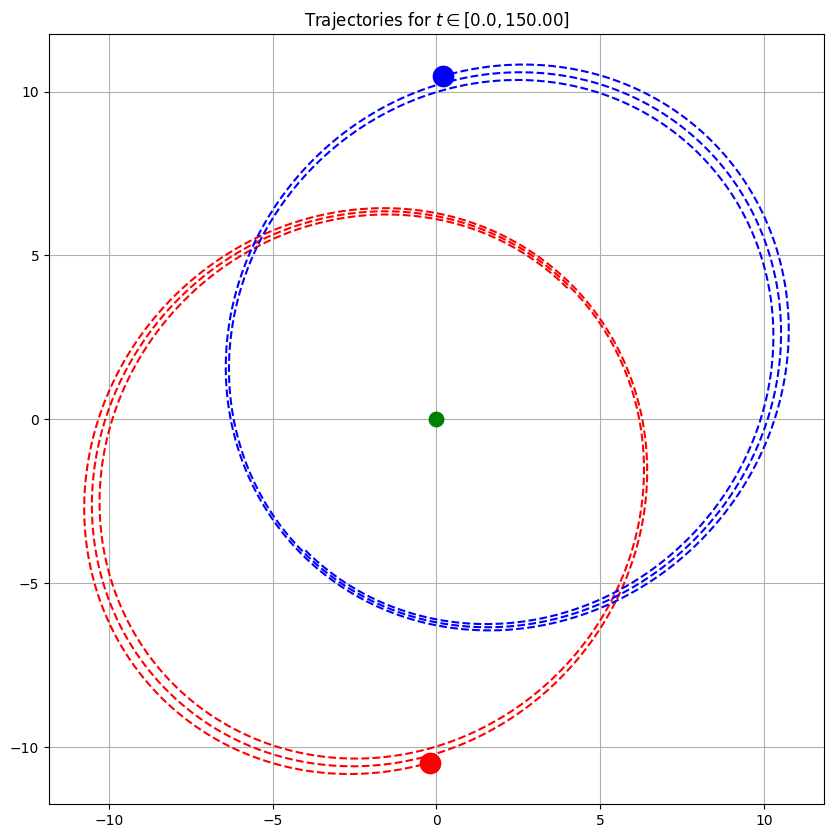

In [8]:
plot_simulation(system1)

## What happens if we introduce a tiny fourth body?

In [9]:
# We make a system like the one above, but where we introduce a TINY fourth body
body4 = Body((-8, 0), (-1, -1), 0.00001)
system2 = System(body1, body2, body3, body4)
system2

System with 4 bodies

In [10]:
print(*[body for _, body in system2.bodies.items()], sep='\n')

Body with mass 5 and initial position (4, 4) and velocity (-1, 1)
Body with mass 5 and initial position (-4, -4) and velocity (1, -1)
Body with mass 3 and initial position (0, 0) and velocity (0, 0)
Body with mass 1e-05 and initial position (-8, 0) and velocity (-1, -1)


In [11]:
# We simulate again
system2.simulate()

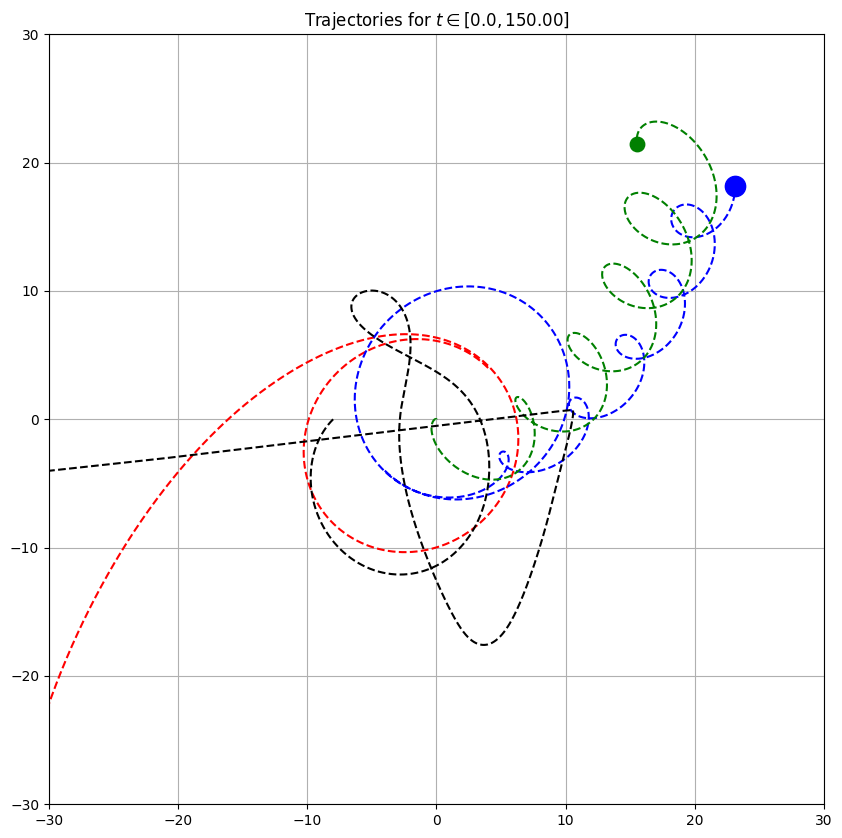

In [12]:
# And plot the curves that they trace out
plot_simulation(system2, (-30, 30))

The fourth body really messes up the trajectories. But it's difficult to see exactly what's going on. We can use an intslider to study subsets of the trajectories.

In [13]:
# Interacting plotting function with widget to allow for closer study of trajectories
@interact(to=IntSlider(value=1, min=0, max=System.N, step=50))
def plot_simulation_subset(to):
    plot_simulation(system2, (-30, 30), (max(to-2500, 0), to))

interactive(children=(IntSlider(value=1, description='to', max=15000, step=50), Output()), _dom_classes=('widg…

It appears as if the tiny body pushes the third on at (0, 0) out of it's position. Then it starts moving and interacting with the others, and the stability is ruined.